In [1]:
import pandas as pd
import dask.dataframe as dd
import time
start_time = time.time()

In [2]:
dtypes_new = {            
                'app'                               : 'uint16',
                'app_channel_unicount'              : 'uint32',
                'appfreq_ip'                        : 'uint32',
                'appfreq_ip_dow_channel'            : 'uint16',
                'channel'                           : 'uint16',
                'channelfreq_ip'                    : 'uint32',
                'channelfreq_ip_app'                : 'uint32',
                'channelfreq_ip_device'             : 'uint32',
                'channelfreq_ip_device_app'         : 'uint32',
                'channelfreq_ip_device_os'          : 'uint32',
                'channelfreq_ip_dow'                : 'uint32',
                'channelfreq_ip_dow_app'            : 'uint16',
                'channelfreq_ip_dow_device'         : 'uint32',
                'channelfreq_ip_dow_hour'           : 'uint16',
                'channelfreq_ip_dow_hour_minute'    : 'uint16',
                'channelfreq_ip_dow_hour_os_app'    : 'uint16',
                'channelfreq_ip_dow_os'             : 'uint16',
                'channelfreq_ip_dow_os_app'         : 'uint16',
                'channelfreq_ip_hour_app'           : 'uint16',
                'channelfreq_ip_hour_device'        : 'uint16',
                'channelfreq_ip_hour_os'            : 'uint16',
                'channelfreq_ip_os'                 : 'uint32',
                'channelfreq_ip_os_app'             : 'uint16',
                'device'                            : 'uint16',
                'devicefreq_ip'                     : 'uint32',
                'devicefreq_ip_app'                 : 'uint32',
                'devicefreq_ip_dow_channel'         : 'uint16',
                'devicefreq_ip_hour'                : 'uint32',
                'devicefreq_ip_os_channel'          : 'uint16',
                'dow'                                : 'uint8',
                'dowfreq_ip'                        : 'uint32',
                'duration_in_hours'                 : 'uint16',
                'hour'                               : 'uint8',
                'hour_working'                       : 'uint8',
                'ip_app_os_unicount'                : 'uint16',
                'ip_device_unicount'                : 'uint32',
                'ip_dow_hour_unicount'              : 'uint16',
                'ip_dow_unicount'                   : 'uint32',
                'os'                                : 'uint16',
                'osfreq_ip'                         : 'uint32',
                'osfreq_ip_channel'                 : 'uint16',
                'osfreq_ip_hour_channel'            : 'uint16',
}

features = list(dtypes_new.keys())
features

['app',
 'app_channel_unicount',
 'appfreq_ip',
 'appfreq_ip_dow_channel',
 'channel',
 'channelfreq_ip',
 'channelfreq_ip_app',
 'channelfreq_ip_device',
 'channelfreq_ip_device_app',
 'channelfreq_ip_device_os',
 'channelfreq_ip_dow',
 'channelfreq_ip_dow_app',
 'channelfreq_ip_dow_device',
 'channelfreq_ip_dow_hour',
 'channelfreq_ip_dow_hour_minute',
 'channelfreq_ip_dow_hour_os_app',
 'channelfreq_ip_dow_os',
 'channelfreq_ip_dow_os_app',
 'channelfreq_ip_hour_app',
 'channelfreq_ip_hour_device',
 'channelfreq_ip_hour_os',
 'channelfreq_ip_os',
 'channelfreq_ip_os_app',
 'device',
 'devicefreq_ip',
 'devicefreq_ip_app',
 'devicefreq_ip_dow_channel',
 'devicefreq_ip_hour',
 'devicefreq_ip_os_channel',
 'dow',
 'dowfreq_ip',
 'duration_in_hours',
 'hour',
 'hour_working',
 'ip_app_os_unicount',
 'ip_device_unicount',
 'ip_dow_hour_unicount',
 'ip_dow_unicount',
 'os',
 'osfreq_ip',
 'osfreq_ip_channel',
 'osfreq_ip_hour_channel']

In [ ]:
categorical_features = ['dow']

In [ ]:
%%time
import xgboost as xgb
import gc

xg_train = xgb.DMatrix(pd.read_csv('X_train.csv', dtype=dtypes_new)[features].values, \
                        label = pd.read_csv('y_train.csv', dtype=dtypes_new, header = -1), \
                        feature_names=features)

xg_test = xgb.DMatrix(pd.read_csv('X_test.csv', dtype=dtypes_new)[features].values, \
                        label = pd.read_csv('y_test.csv', dtype=dtypes_new, header = -1), \
                        feature_names=features)

In [5]:
# import numpy as np
# learning_rates = []
# for x in np.arange(1, 101, 1):
#     learning_rates.append(round(0.5 * pow(0.98, x), 3))
    
# # define a function that returns the decaying learning rate
# def custom_rates(boosting_round, num_boost_round):
#     return round(0.5 * pow(0.95, boosting_round), 3)

In [6]:
label = dd.read_csv('y_train.csv', dtype=dtypes_new, header = -1)
is_attributed_value_counts = label[0].value_counts()
attributed_ratio = is_attributed_value_counts[1]/is_attributed_value_counts[0]

print('attributed:', is_attributed_value_counts[0])
print('not attributed:', is_attributed_value_counts[1])
print('attributed ratio: {0:.6f}'.format(attributed_ratio))
print('positive label weight benchmark: {0:.6f}'.format(1/attributed_ratio))

In [ ]:
%%time
# setup parameters for xgboost
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

params = {
            'objective': 'binary:logistic', 
            'eta': 0.05,
            'tree_method': "hist", # fast histogram optimized approximate greedy algorithm
            'grow_policy': "lossguide",
            'max_leaves': 1000, # maximum number of nodes to be added
            'max_depth': 0, # no limit
            'alpha': 0, # L1 regularization term on weights
            'lambda': 0, # L2 regularization term on weights
            'min_child_weight': 0,
#             'max_delta_step': 1,# maximum delta step we allow each tree's weight estimation to be
            'scale_pos_weight': round(1/attributed_ratio),
            'eval_metric': 'auc', 
            'nthread': 16,
          }

num_boost_round = 500
watchlist = [(xg_train, 'train'), (xg_test, 'valid')]

# bst = xgb.train(params, xg_train, num_boost_round, watchlist, callbacks=[xgb.callback.reset_learning_rate(custom_rates)])
# bst = xgb.train(params, xg_train, num_boost_round, watchlist, callbacks=[xgb.callback.reset_learning_rate(learning_rates)])
# bst = xgb.train(params, xg_train, num_boost_round, watchlist, early_stopping_rounds=3)
bst = xgb.train(params, xg_train, num_boost_round, watchlist, early_stopping_rounds=50)

[0]	train-auc:0.975495	valid-auc:0.967326
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.976114	valid-auc:0.969129
[2]	train-auc:0.976594	valid-auc:0.969926
[3]	train-auc:0.977103	valid-auc:0.970797
[4]	train-auc:0.977515	valid-auc:0.971691
[5]	train-auc:0.977886	valid-auc:0.972269
[6]	train-auc:0.978127	valid-auc:0.972636
[7]	train-auc:0.978341	valid-auc:0.972831
[8]	train-auc:0.978629	valid-auc:0.972994
[9]	train-auc:0.978793	valid-auc:0.973232
[10]	train-auc:0.978982	valid-auc:0.973299
[11]	train-auc:0.979249	valid-auc:0.97352
[12]	train-auc:0.979471	valid-auc:0.97372
[13]	train-auc:0.979724	valid-auc:0.973772
[14]	train-auc:0.979979	valid-auc:0.973825
[15]	train-auc:0.980227	valid-auc:0.973879
[16]	train-auc:0.980444	valid-auc:0.974008
[17]	train-auc:0.980763	valid-auc:0.974075
[18]	train-auc:0.981024	valid-auc:0.974299
[19]	train-auc:0.98127	valid-auc:0.974338
[20]	train

In [ ]:
# best train-auc so far: 0.996623
# best valid-auc so far: 0.977117

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=150)
xgb.plot_importance(bst, ax=ax)
fig.savefig('feature_importance.png')

In [6]:
prediction = bst.predict(xgb.DMatrix(test_data_processed))

del test_data_processed
gc.collect()

prediction

array([0.18388285, 0.0244378 , 0.01018693, ..., 0.06214212, 0.03661466,
       0.00707424], dtype=float32)

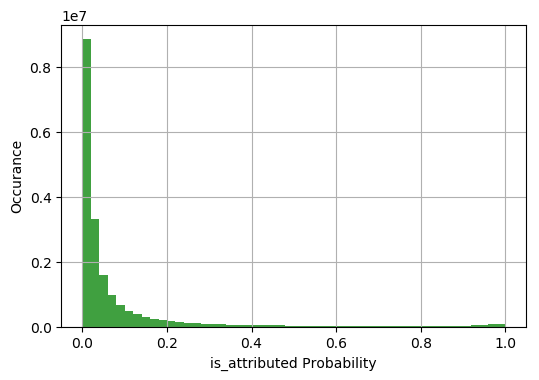

In [8]:
plt.figure(figsize=(6,4), dpi=100)

n, bins, patches = plt.hist(prediction, 50, facecolor='g', alpha=0.75)

plt.xlabel('is_attributed Probability')
plt.ylabel('Occurance')
plt.grid(True)
plt.show()

In [9]:
%%time
click_id = dd.read_csv('click_id.csv', dtype=dtypes_new, header = -1)
submission = pd.DataFrame({'click_id': click_id[0], 'is_attributed': prediction})
submission.to_csv('submission.gz', compression='gzip', index=False)

# del prediction
# gc.collect()

CPU times: user 3min 22s, sys: 216 ms, total: 3min 22s
Wall time: 3min 22s


In [10]:
# XGBoost classification with impactful features using larger training data
submission.head(10)

,click_id,is_attributed
0,0,0.313584
1,1,0.027138
2,2,0.017415
3,3,0.044356
4,4,0.017563
5,5,0.059774
6,6,0.019303
7,7,0.203314
8,9,0.127836
9,8,0.004745


In [11]:
print('total running hours: {0:.3f}'.format((time.time() - start_time)/3600))

total running hours: 1.975


In [44]:
# !kaggle competitions submit -c talkingdata-adtracking-fraud-detection -f submission.gz -m "AWS more boosting with limited training data"